In [1]:
from matplotlib import pyplot as plt
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.providers.aer.pulse_new.de.DE_Problems import BMDE_Problem, SchrodingerProblem, LindbladProblem
from qiskit.providers.aer.pulse_new.de.DE_Solvers import BMDE_Solver
from qiskit.providers.aer.pulse_new.de.solve import solve
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.models.signals import VectorSignal, Constant, Signal
from qiskit.providers.aer.pulse_new.models.quantum_models import HamiltonianModel, QuantumSystemModel

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 1. Basic functionality

In [2]:
r = 1.
w = 1.
signals = [Constant(1.), Signal(1., w)]
operators = [2 * np.pi * w * Z/2, 2 * np.pi * r * X/2]

hamiltonian = HamiltonianModel(operators=operators, signals=signals)

Evaluate at a given time.

In [3]:
print(hamiltonian.evaluate(0.1))
print(hamiltonian.evaluate(0.2))

[[ 3.14159265+0.j  2.54160185+0.j]
 [ 2.54160185+0.j -3.14159265+0.j]]
[[ 3.14159265+0.j  0.97080552+0.j]
 [ 0.97080552+0.j -3.14159265+0.j]]


Get the drift (terms corresponding to `Constant` coefficients). In this case just the first term.

In [4]:
hamiltonian.drift

array([[ 3.14159265+0.j,  0.        +0.j],
       [ 0.        +0.j, -3.14159265+0.j]])

# 2. Enter a frame

In this case, we will enter the frame of the drift.

In [5]:
hamiltonian.frame = hamiltonian.drift

Evaluate again.

In [6]:
print(hamiltonian.evaluate(0.1))
print(hamiltonian.evaluate(0.2))

[[-4.44089210e-16+0.j          2.05619909e+00+1.49391608j]
 [ 2.05619909e+00-1.49391608j  4.44089210e-16+0.j        ]]
[[0.       +0.j         0.2999954+0.92329092j]
 [0.2999954-0.92329092j 0.       +0.j        ]]


In the above, the diagonal part of the model is now $0$, as it has been subtracted when entering the frame (which is coincidentally the diagonal). The off-diagonal part, which ordinarily is $2 \pi r X / 2$ multiplied with an oscillating signal, is now rotating between $X$ and $Y$ as a result of being in the frame. We can plot the real and imaginary parts of the first off-diagonal to see this.

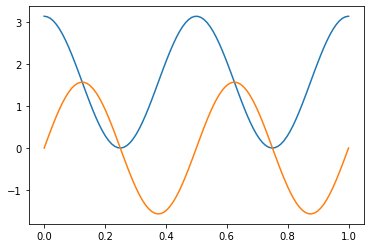

In [7]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([hamiltonian.evaluate(t) for t in t_vals])
offdiag_re = model_vals[:, 0, 1].real
offdiag_im = model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_re)
plt.plot(t_vals, offdiag_im)

In the above, the real part is blue, corresponding to the $X$ operator, and the imaginary part is yellow, corresponding to the $Y$ operator.

# 3. Set cutoff frequency

Next, we add a cutoff frequency, which eliminates terms in the model oscillating above a given frequency. The frequencies for a given term are a combination of oscillations due to the chosen frame, as well as oscillations due to signal carrier frequencies.

The classic RWA uses the model we have defined, and sets the cutoff to `2*w`.

In [8]:
hamiltonian.cutoff_freq = 2*w

We now perform the same plot as above.

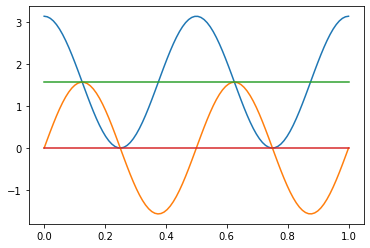

In [9]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([hamiltonian.evaluate(t) for t in t_vals])
offdiag_re_cutoff = model_vals[:, 0, 1].real
offdiag_im_cutoff = model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_re)
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re_cutoff)
plt.plot(t_vals, offdiag_im_cutoff)

Observe, the real part is now constant at $\pi /2$, which is the average of the oscillation in the previous section (similarly, the imaginary part is constant at the corresponding average of $0$).

# 4. Solve Shrodinger equation with a HamiltonianModel

In [10]:
r = 1.
w = 1.
signals = [Constant(1.), Signal(1., w)]
operators = [2 * np.pi * w * Z/2, 2 * np.pi * r * X/2]

hamiltonian = HamiltonianModel(operators=operators, signals=signals)
se_problem = SchrodingerProblem(hamiltonian=hamiltonian, y0=np.array([1., 0.]), t0=0.)

In [11]:
options = DE_Options(atol=1e-10, rtol=1e-10)
solver = BMDE_Solver(se_problem, options=options)
solver.integrate(1./r)
solver.y

array([-1.2926258e-02-0.13421715j,  1.0369228e-11+0.99086763j])

Note: the RWA is not a great approximation for this system, hence the state not being inverted very well.

In [18]:
# simpler flow with solve
r = 1.
w = 1.
signals = [Constant(1.), Signal(1., w)]
operators = [2 * np.pi * w * Z/2, 2 * np.pi * r * X/2]

hamiltonian = HamiltonianModel(operators=operators, signals=signals)
se_problem = SchrodingerProblem(hamiltonian=hamiltonian, y0=np.array([1., 0.]), interval=[0., 1./r])
solve(se_problem)

array([-1.29259609e-02-0.13421691j,  6.42658732e-09+0.99086772j])

# 5. Solving a quantum model

In [12]:
r = 0.02
w = 5.
signals = [Constant(1.), Signal(1., w)]
operators = [2 * np.pi * w * Z/2, 2 * np.pi * r * X/2]

hamiltonian = HamiltonianModel(operators=operators, signals=signals)

# put one noise operator
noise_ops = np.array([[[0., 1.], [1., 0.]]])
#noise_signals = [Signal(1., 1.)]

q_model = QuantumSystemModel(hamiltonian=hamiltonian, noise_operators=noise_ops)#, noise_signals=noise_signals)

In [14]:
y0 = np.array([[0.5, 0.5], [0.5, 0.5]])#/2
de_problem = LindbladProblem(q_model=q_model, y0=y0, t0=0., cutoff_freq=30*w)
options = DE_Options(method='scipy-RK45', atol=1e-10, rtol=1e-10)
solver = BMDE_Solver(de_problem, options=options)

In [15]:
%time solver.integrate(1/r)

CPU times: user 783 ms, sys: 2.35 ms, total: 786 ms
Wall time: 784 ms


In [16]:
solver.y

array([[5.00000000e-01-1.08465667e-19j, 1.11777094e-09+2.98351638e-10j],
       [1.11777095e-09-2.98351630e-10j, 5.00000000e-01+1.08465667e-19j]])

In [17]:
np.linalg.eig(solver.y)

(array([0.5-4.71884061e-18j, 0.5+4.61037510e-18j]),
 array([[ 0.71524273+0.j        ,  0.67523648+0.18023183j],
        [-0.67523649+0.18023184j,  0.71524275+0.j        ]]))